# OPTIMIZATION

##Problem and task description

###The problem: implied volatility

**Field**: quantitative finance

**Basic info**:
Volatility of a financial asset - the degree of variation of the prices. Implied volatility is the market's expectation for the future volatility of an underlying asset until the maturity of a derivative contract. It's used by market players to price derivatives.

**Task**: minimize the difference between market and real volatility

### Optimization algorithms used:
- Adaptive Momentum (Adam) Algorithm
- Particles Sworm Optimization (PSO) Algorithm
- Genetic Algorithm (Standard Genetic Algorithm)
- Firefly Algorithm

In [2]:
#!/usr/bin/env python
# coding: utf-8

!pip install numdifftools
import numpy as np
import numdifftools as nd

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as si
import scipy.optimize as sciopt
import pandas as pd
import plotly.express as px
import copy
#from lib import *
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
from sklearn.decomposition import PCA

def get_svi_curve(parameters, moneyness):
    a = parameters[0]
    b = parameters[1]
    rho = parameters[2]
    m = parameters[3]
    sigma = parameters[4]
    return [a+b*(rho*(k-m)+np.sqrt((k-m)**2 + sigma**2)) for k in moneyness]


moneyness = np.linspace(-3, 1, 50)

parameters = [-0.04, 0.15, 0.5, 0.3, 0.3]  # a,b, rho, m, sigma


# g-function used to check butterfly arbitrage
# SVI value
def sviCurve(a, b, rho, m, tau, k):
    # k is moneyness
    y = a + b * (rho * (k - m) + np.sqrt((k - m) ** 2
                                         + tau ** 2))
    if y >= 0:
        return np.sqrt(y)  # it returns the square root of the variance
    else:
        return 0

# first derivate of SVI formula


def sviCurveDerivate(b, rho, m, tau, k):
    return b * (rho + (k - m) / np.sqrt((k - m) ** 2 + tau ** 2))

# second derivate of SVI formula


def sviCurve2ndDerivate(b, m, tau, k):
    return b * tau * tau / np.power((k - m) ** 2 + tau ** 2, 1.5)


def gFunction(a, b, rho, m, tau, S, time2Maturity, vecStrike):
    moneyness = [np.log(k / S) for k in vecStrike]
    g = []
    for k in moneyness:
        w = (sviCurve(a, b, rho, m, tau, k)**2) * time2Maturity
        wd = sviCurveDerivate(b, rho, m, tau, k) * time2Maturity
        wdd = sviCurve2ndDerivate(b, m, tau, k) * time2Maturity
        if w != 0:
            g.append((1 - k * wd / (2 * w)) ** 2 -
                     (wd * wd / 4) * (1 / w + 0.25) + wdd / 2)
        else:
            g.append(-1)
    return g


param_names = ['a', 'b', 'rho', 'm', 'tau']


# =====================================================================================
# functions for optimization
# =====================================================================================
# butterlfy arbitrage verification:
# volCoef-> array storing SVI parameters
# vecStrikePrice-> array containing strike prices
# S-> spot price
def butterflyArbitrage(volCoef, S, time2Maturity, vecStrikePrice):
    a = volCoef[0]
    b = volCoef[1]
    rho = volCoef[2]
    m = volCoef[3]
    tau = volCoef[4]
    g = gFunction(a, b, rho, m, tau, S, time2Maturity, vecStrikePrice)
    # регуляризация: штраф, если g <= 0
    return np.exp([0 if gi >= 0 else 1 for gi in g])

# check if calculated value is within bid-ask spread
# pAdjusted-> array of adjusted values ([sp] by Black-Scholes model)
# bid, ask-> arrays with the minimum and maximum values of the market


def envelopeCondition(pAdjusted, bid, ask):
    return np.exp(np.clip([
        0 if (pi >= bi and pi <= ai)
        # если цена вне спреда, то пытаемся устремить ее к центру спреда
        else 2*np.fabs(pi-(ai+bi)/2)/(ai-bi)
        for pi, bi, ai in zip(pAdjusted, bid, ask)],
        a_min=None,
        a_max=10))
# objective function
# X-> array with SVI parameters
# optionType-> string 'Call' or 'Put'
# volMarket, bid, ask-> arrays with market data of implied volatility
# optionType-> string 'Call' or 'Put'


def euro_vanilla_call(S, K, T, r, sigma):

    # S: spot price
    # K: strike price
    # T: time to maturity
    # r: interest rate
    # sigma: volatility of underlying asset

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

    call = (S * si.norm.cdf(d1, 0.0, 1.0) - K *
            np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))

    return call


def getVolatility(marketPrices, S0, time2Maturity, vecStrike, r):
    bounds = [(0, 2)]
    vol = []
    for k, mp in zip(vecStrike, marketPrices):
        args = (S0, k, r, time2Maturity, mp)
        volOptimResults = sciopt.differential_evolution(
            vol_market, args=args, bounds=bounds, tol=1E-8)
        # решаем уравение Блэка-Шоулза относительно волатильности при известных ценах опционов
        vol.append(volOptimResults.x[0])
    return vol


def vol_market(x, S0, k, r, time2Maturity, marketPrice):
    # x - волатильность
    price_by_model = euro_vanilla_call(S0, k, time2Maturity, r, x)
    return (price_by_model - marketPrice)**2


def OF(X, vol_market, bid, ask, S0, time2Maturity, vecStrikePrice):
    # [sp] X are parameters
    # [sp] S0 - изначальная цена базового актива
    # [sp] ask - волатильность ask-цены
    #
    moneyness = [np.log(k / S0) for k in vecStrikePrice]
    vol_model = get_svi_curve(X, moneyness)

    # penalizations
    consButterfly = butterflyArbitrage(X, S0, time2Maturity, vecStrikePrice)
    # envelopeCondition(pAdjusted, bid, ask)
    # TODO подключить регуляризацию против арбитража
    consEnvelope = np.array([1]*len(vol_market))

    OF = np.array([((volAdj*np.sin(X[3]))/volMar - 1) * bi*ei
    # OF = np.array([((volAdj)/volMar - 1) * bi*ei
                   for volAdj, volMar, bi, ei in
                   zip(vol_model, vol_market, consButterfly, consEnvelope)])
    return np.sum(OF**2)


df = pd.read_csv('option_price.csv', )
s0 = 169.59
TIME2MATURITY = 1/360
R = .05


def extract_data(df):
    res = df[['bid', 'ask', 'strike']].copy()
    res['mid'] = (res.bid+res.ask)/2
    res['moneyness'] = [np.log(k/s0) for k in res.strike]
    res['volMarketData'] = getVolatility(
        res.mid, s0, TIME2MATURITY, res.strike, R)
    res['volBidMarketData'] = getVolatility(
        res.bid, s0, TIME2MATURITY, res.strike, R)
    res['volAskMarketData'] = getVolatility(
        res.ask, s0, TIME2MATURITY, res.strike, R)
    return res


vol = extract_data(df)

# константы и данные
args = (vol['volMarketData'],
        vol['volBidMarketData'],
        vol['volAskMarketData'],
        s0,
        TIME2MATURITY,
        vol.strike)
bounds = [(0., 5.), (-5., 5.), (-5., 5.), (-5., 5.), (0., 5.)]

### Adam algorithm


In [ ]:
# Adam optimization algorithm
def adam(objective, args, bounds, n_iter, alpha, beta1=0.9, beta2=0.999, eps=1e-6):
    # Generate an initial point with bounds for each variable
    x = [np.random.uniform(b[0], b[1]) for b in bounds]
    x = np.array(x)

    best_score = objective(x, *args)
    best_params = x
    # Initialize Adam moments
    s = np.zeros(len(bounds))
    v = np.zeros(len(bounds))

    iters_without_improvements = 0

    # Run the gradient descent updates
    for t in range(n_iter):
        # Calculate gradient g(t)
        grads = nd.Gradient(objective)(x, *args)
        # print(grads)

        # Update parameters using Adam
        s = beta1 * s + (1.0 - beta1) * grads
        v = beta2 * v + (1.0 - beta2) * grads ** 2
        s_hat = s / (1.0 - beta1 ** (t + 1))
        v_hat = v / (1.0 - beta2 ** (t + 1))
        x = x - alpha * s_hat / (np.sqrt(v_hat) + eps)

        # Clip the values to stay within bounds
        x = np.clip(x, [b[0] for b in bounds], [b[1] for b in bounds])

        # Evaluate candidate point
        score = objective(x, *args)
        if score < best_score:
          best_score = score
          best_params = x
          iters_without_improvements = 0
        if best_score - score < 0.1:
          iters_without_improvements += 1

        # if iters_without_improvements >= 10:
        #   break
        # Report progress
        if t%100 ==0:
          print(f"t={t}, score = {score}")

    return [best_params, best_score]

In [ ]:
n_iter = 1000
alpha = 0.5
bounds = [(0., 5.), (-5., 5.), (-5., 5.), (-5., 5.), (0., 5.)]

results_adam = []

for i in range(15):
    print(f"Iteration {i+1}")
    best, score = adam(OF, args, bounds, n_iter, alpha)
    results_adam.append((best, score))

print('Done!')
print('f(%s) = %f' % (best, score))

In [ ]:
experiment_scores_adam = [score for _, score in results_adam]
experiment_scores_adam

In [3]:
saved_experiment_scores_adam = [36.07096203519172,
 36.65723184116535,
 34.44023833720488,
 35.79462241864343,
 34.18330707445514,
 37.550547323118465,
 46.90416977772818,
 40.817275321170065,
 35.63769005089375,
 47.566260345468805,
 35.574382355610744,
 34.48849820206591,
 34.28012782155055,
 34.73019101455041,
 35.940772052288956]

### PSO algorithm

In [ ]:
import numpy as np

def pso(cost_func, args, dim, bounds, num_particles=100, max_iter=150, w=1e-6, c1=1, c2=2):
    bounds = np.array(bounds)  # Convert bounds to NumPy array
    # Initialize particles and velocities
    particles = np.random.uniform(low=bounds[:, 0], high=bounds[:, 1], size=(num_particles, dim))
    velocities = np.zeros((num_particles, dim))

    # Initialize the best positions and fitness values
    best_positions = np.copy(particles)
    best_fitness = np.array([cost_func(p, *args) for p in particles])
    swarm_best_position = best_positions[np.argmin(best_fitness)]
    swarm_best_fitness = np.min(best_fitness)

    # Iterate through the specified number of iterations, updating the velocity and position of each particle at each iteration
    for i in range(max_iter):
        # Update velocities
        r1 = np.random.uniform(0, 1, (num_particles, dim))
        r2 = np.random.uniform(0, 1, (num_particles, dim))
        velocities = w * velocities + c1 * r1 * (best_positions - particles) + c2 * r2 * (swarm_best_position - particles)

        # Update positions while respecting bounds
        particles += velocities
        particles = np.clip(particles, bounds[:, 0], bounds[:, 1])

        # Evaluate fitness of each particle
        fitness_values = np.array([cost_func(p, *args) for p in particles])

        # Update best positions and fitness values
        improved_indices = np.where(fitness_values < best_fitness)
        best_positions[improved_indices] = particles[improved_indices]
        best_fitness[improved_indices] = fitness_values[improved_indices]
        if np.min(fitness_values) < swarm_best_fitness:
            swarm_best_position = particles[np.argmin(fitness_values)]
            swarm_best_fitness = np.min(fitness_values)
            if i%100==0:
              print(f"t={i}, score = {swarm_best_fitness}")
            # print('>%d f(%s) = %.5f' % (i, swarm_best_position, swarm_best_fitness))

    # Return the best solution found by the PSO algorithm
    return swarm_best_position, swarm_best_fitness

In [ ]:
bounds = [(0., 5.), (-5., 5.), (-5., 5.), (-5., 5.), (0., 5.), (-5., 5.)]
results_pso = []

for i in range(15):
    print(f"Iteration {i+1}")
    best_params, best_fitness = pso(OF, args, dim=6, bounds=bounds)
    results_pso.append((best_params, best_fitness))

Iteration 1
t=0, score = 145.23661901720808
Iteration 2
t=0, score = 57.16665294590715
Iteration 3
t=0, score = 102.38968155957471
Iteration 4
t=0, score = 144.14249636071477
Iteration 5
t=0, score = 106.36621216661216
t=100, score = 43.980266857110735
Iteration 6
t=0, score = 52.54646131849593
t=100, score = 43.95948015180645
Iteration 7
t=100, score = 43.958572530654216
Iteration 8
t=0, score = 77.53260797370137
t=100, score = 43.91558346808831
Iteration 9
t=0, score = 68.45915354959351
t=100, score = 43.9676520428397
Iteration 10
t=100, score = 43.95596314248118
Iteration 11
t=0, score = 106.50862631355719
Iteration 12
t=0, score = 323.6149183554566
Iteration 13
t=100, score = 43.97776340017147
Iteration 14
t=0, score = 62.710408226755376
t=100, score = 43.98826156719967
Iteration 15
t=0, score = 54.76428107753203
t=100, score = 44.15680933248842


In [ ]:
experiment_scores_pso = [score for _, score in results_pso]
experiment_scores_pso

[43.786078022502934,
 43.96756661982523,
 44.232735525220804,
 43.95559676817406,
 43.980261053500506,
 43.95945300791648,
 43.95857253039801,
 43.91126722794289,
 43.96765203476996,
 43.955963127873005,
 43.97822885556753,
 43.963136348764,
 43.97776339961629,
 43.98822507452351,
 44.15366978331451]

In [4]:
saved_experiment_scores_pso = [43.786078022502934,
 43.96756661982523,
 44.232735525220804,
 43.95559676817406,
 43.980261053500506,
 43.95945300791648,
 43.95857253039801,
 43.91126722794289,
 43.96765203476996,
 43.955963127873005,
 43.97822885556753,
 43.963136348764,
 43.97776339961629,
 43.98822507452351,
 44.15366978331451]

### Genetic algorithm
Standard Genetic Algorithm (SGA) with a binary representation, single-point crossover, and bit flip mutation.

In [ ]:
from numpy.random import randint
from numpy.random import rand
# decode bitstring to numbers
def decode(bounds, n_bits, bitstring):
	decoded = list()
	largest = 2**n_bits
	for i in range(len(bounds)):
		# extract the substring
		start, end = i * n_bits, (i * n_bits)+n_bits
		substring = bitstring[start:end]
		# convert bitstring to a string of chars
		chars = ''.join([str(s) for s in substring])
		# convert string to integer
		integer = int(chars, 2)
		# scale integer to desired range
		value = bounds[i][0] + (integer/largest) * (bounds[i][1] - bounds[i][0])
		# store
		decoded.append(value)
	return decoded

# tournament selection
def selection(pop, scores, k=3):
	# first random selection
	selection_ix = randint(len(pop))
	for ix in randint(0, len(pop), k-1):
		# check if better (e.g. perform a tournament)
		if scores[ix] < scores[selection_ix]:
			selection_ix = ix
	return pop[selection_ix]

# crossover two parents to create two children
def crossover(p1, p2, r_cross):
	# children are copies of parents by default
	c1, c2 = p1.copy(), p2.copy()
	# check for recombination
	if rand() < r_cross:
		# select crossover point that is not on the end of the string
		pt = randint(1, len(p1)-2)
		# perform crossover
		c1 = p1[:pt] + p2[pt:]
		c2 = p2[:pt] + p1[pt:]
	return [c1, c2]

# mutation operator
def mutation(bitstring, r_mut):
	for i in range(len(bitstring)):
		# check for a mutation
		if rand() < r_mut:
			# flip the bit
			bitstring[i] = 1 - bitstring[i]

# genetic algorithm
def genetic_algorithm(objective, args, bounds, n_bits, n_iter, n_pop, r_cross, r_mut):
	# initial population of random bitstring
	pop = [randint(0, 2, n_bits*len(bounds)).tolist() for _ in range(n_pop)]
	# keep track of best solution
	best, best_eval = 0, objective(decode(bounds, n_bits, pop[0]), *args)
	# enumerate generations
	for gen in range(n_iter):
		# decode population
		decoded = [decode(bounds, n_bits, p) for p in pop]
		# evaluate all candidates in the population
		scores = [objective(d, *args) for d in decoded]
		# check for new best solution
		for i in range(n_pop):
			if scores[i] < best_eval:
				best, best_eval = pop[i], scores[i]
				if i%100==0:
					print(f"t={gen}, score = {scores[i]}")
				# print(">%d, new best f(%s) = %f" % (gen,  decoded[i], scores[i]))
		# select parents
		selected = [selection(pop, scores) for _ in range(n_pop)]
		# create the next generation
		children = list()
		for i in range(0, n_pop, 2):
			# get selected parents in pairs
			p1, p2 = selected[i], selected[i+1]
			# crossover and mutation
			for c in crossover(p1, p2, r_cross):
				# mutation
				mutation(c, r_mut)
				# store for next generation
				children.append(c)
		# replace population
		pop = children
	return [best, best_eval]

In [ ]:
n_iter = 150
n_bits = 16
n_pop = 3000
r_cross = 1e-3
r_mut = 1.0 / (float(n_bits) * len(bounds))

results_ge = []

for _ in range(15):
    best, score = genetic_algorithm(OF, args, bounds, n_bits, n_iter, n_pop, r_cross, r_mut)
    print('Done with run %d!' % (_ + 1))
    decoded = decode(bounds, n_bits, best)
    print('f(%s) = %f' % (decoded, score))
    results_ge.append((decoded, score))

print('All runs completed!')


In [ ]:
experiment_scores_sga = [score for _, score in results_ge]
experiment_scores_sga

In [5]:
saved_experiment_scores_sga = [30.047822096445064,
 29.87909772212442,
 30.049678285136473,
 29.911003257855977,
 30.346795683011845,
 30.80965065100457,
 30.179713746137836,
 30.335531995099082,
 30.334848703088216,
 30.25919137658924,
 30.027865497320484,
 29.690368399039574,
 29.68485051097652,
 30.335531995099082,
 30.416124341881726]

### Firefly algorithm


In [ ]:
scale = np.array([1.01696668e-01, -4.27115140e-04, -2.66334757e+00,  1.26552123e+00,
                  2.60217237e+00])


def in_bounds(x, bounds):
    return all(x[i] >= bounds[i][0] and x[i] <= bounds[i][1] for i in range(len(x)))


def objective(x):
    return OF(x, *args)


def exp_brightness(gamma, r):
    return np.exp(-gamma*r)


def get_firefly(bounds, d):
    res = []
    for b in bounds:
        res.append(np.random.uniform(b[0], b[1]))
    return np.array(res)


def get_firefly_population(n, bounds, d):
    res = []
    for i in range(n):
        res.append(get_firefly(bounds, d))
    return res


def converged(population):
    d = len(population[0])
    for i in range(d):
        max_in_param = - np.inf
        min_in_param = np.inf
        for p in population:
            max_in_param = max(max_in_param, p[i])
            min_in_param = min(min_in_param, p[i])
        if abs(max_in_param - min_in_param) > 0.0001:
            return False
    return True


def firefly(init_population, bounds, iterations_cnt, alpha, beta, gamma,  brightness):
    """
    @param: alpha - сила шума
    @param: beta - мера влечения
    @param: gamma - мера затухания яркости в зависимости от расстояния

    """
    population = copy.deepcopy(init_population)
    firefly_vals = [np.inf]*len(population)
    m = len(population)
    d = len(population[0])
    best_firefly = None
    best_val = np.inf
    history = []
    for k in range(iterations_cnt):
        for i, a in enumerate(population):
            for j, b in enumerate(population):
                val_a = objective(a)
                val_b = objective(b)
                firefly_vals[i] = val_a
                firefly_vals[j] = val_b
                if val_b < val_a:
                    if val_b < best_val:
                        best_val = val_b
                        best_firefly = b
                    r = np.linalg.norm(b-a)
                    delta = beta * brightness(gamma, r)*(b-a)
                    noise = np.random.random(d) * delta * 0.1 * alpha
                    delta += noise

                    if in_bounds(a+delta, bounds):
                        a += delta
                        # print(delta)
                    new_val_a = objective(a)
                    if new_val_a < best_val:
                        best_val = new_val_a
                        best_firefly = a
                    firefly_vals[i] = new_val_a

        # best_index = firefly_vals.index(min(firefly_vals))
        # best_val = firefly_vals[best_index]
        # best_firefly = population[best_index]
        history.append(best_val)
        if converged(population):
            break

    return best_firefly, round(best_val, 2), history, population

In [ ]:
results_ff = []
results_ff_by_params = {}
best_ff_score = np.inf
best_ff_params = []
grid = product(np.linspace(0.01, 1, 2),
               np.linspace(0.01, 1, 5),
               np.linspace(0.01, 1, 5)
               )
for it, (alpha, beta, gamma) in enumerate([(1, .25, .01)]*15):
    # for _ in range(15):
    init_population = get_firefly_population(50, bounds, d=5)
    best_params, best_val, history, population = firefly(init_population,
                                                         bounds,
                                                         iterations_cnt=50,
                                                         alpha=alpha,
                                                         beta=beta,
                                                         gamma=gamma,
                                                         brightness=exp_brightness)
    score = best_val
    plt.plot(history)
    plt.title(f"{(alpha, beta, gamma)} , score = {score}")
    plt.show()
    results_ff_by_params[(alpha, beta, gamma)] = score
    if it % 50 == 0:
        print(it, score)

    if score < best_ff_score:
        best_ff_score = score
        best_ff_params = best_params
        results_ff_by_params[(alpha, beta, gamma)] = best_ff_score
        print(f"[{it}] {round(best_ff_score,3)}")
    results_ff.append((best_params, score))
print(f'Best: {best_ff_score}')

In [ ]:
experiment_scores_ff = [score for _, score in results_ff]

In [6]:
saved_experiment_scores_ff = [34.11, 34.55, 34.3, 34.08, 34.29, 35.62,
                              34.39, 37.76, 34.02, 35.02, 33.91, 45.98, 33.96, 33.97, 37.29]

### Стат-тест

Визуализируем распределения результатов запусков с помощью 'ящиков с усами'

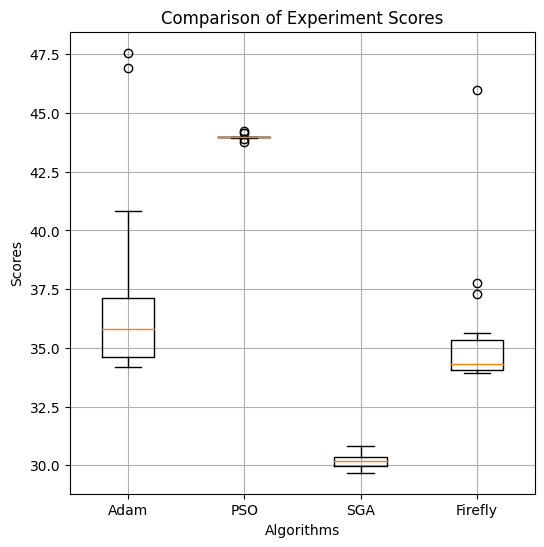

In [7]:
# Combine the lists into a single list of lists
data_to_plot = [saved_experiment_scores_adam, saved_experiment_scores_pso,
                saved_experiment_scores_sga, saved_experiment_scores_ff]

# Names for the algorithms
algorithm_names = ['Adam', 'PSO', 'SGA', 'Firefly']

# Create a boxplot
plt.figure(figsize=(6, 6))
plt.boxplot(data_to_plot, labels=algorithm_names)
plt.title('Comparison of Experiment Scores')
plt.ylabel('Scores')
plt.xlabel('Algorithms')
plt.grid(True)
plt.show()

Проведем тест Friedman ranking test

In [ ]:
!pip install scikit_posthocs

In [9]:
# Importing libraries
from scipy import stats
import scikit_posthocs as sp
import numpy as np


# Conduct the Friedman Test
res=stats.friedmanchisquare(saved_experiment_scores_adam, saved_experiment_scores_pso, saved_experiment_scores_sga, saved_experiment_scores_ff)
res.pvalue


3.3686248238358685e-08

Дополнительно, проверим Nemenyi test

In [10]:
# Combine ащгк groups into one array
data = np.array([saved_experiment_scores_adam, saved_experiment_scores_pso, saved_experiment_scores_sga, saved_experiment_scores_ff])

# Conduct the Nemenyi post-hoc test
results = sp.posthoc_nemenyi_friedman(data.T)

# Convert the results to a pandas DataFrame
df_results = pd.DataFrame(results)

# Rename the columns and indices
df_results = df_results.rename(columns={0: 'Adam', 1: 'PSO', 2: 'SGA', 3: 'Firefly'},
                               index={0: 'Adam', 1: 'PSO', 2: 'SGA', 3: 'Firefly'})

df_results

,Adam,PSO,SGA,Firefly
Adam,1.000000,0.255307,0.001000,0.490749
PSO,0.255307,1.000000,0.001000,0.006287
SGA,0.001000,0.001000,1.000000,0.036286
Firefly,0.490749,0.006287,0.036286,1.000000
